# Regularization

Regularization is a broad group of techniques intended for reducing overfitting.
Most regularizations methods aim at introducing a preference for simpler models,
instead of forcing simpler models through reduced model capacity. 
A soft preference is more diserable because the algorithm can still choose a very complex model,
but regularization requires such complex model to have a significant performance improvement over simpler models.

$$ 
\text{Cost}\big(\textbf{Y}, \hat{\textbf{Y}}, \textbf{W}\big) 
= \text{Supervised Cost}(\textbf{Y}, \hat{\textbf{Y}}) 
+ \alpha * \text{Regularization Cost}(\textbf{W}) 
$$

Hyperparameter $ \alpha \in [0, \infty] $ controls the balance between supervised and regularization costs. It's advised to first train a model that has the lowest possible training cost, and only then enable regularization to improve the validation metrics.

### Vector Norms

Most frequently used regularization methods are based on the vector norm of the weights. Vector norms are functions that measure the magnitude of a vector with a single scalar, and satisfy the following properties:

$ f(\textbf{v}) \in ℝ^n \rightarrow ℝ $

$ f(\textbf{a} + \textbf{b}) \le f(\textbf{a}) + f(\textbf{b}) $

$ f(c * \textbf{a}) = |c| f(\textbf{a}) $

$ f(\textbf{a}) = 0 \rightarrow \textbf{a} = \textbf{0} $

In short, the vector norm grows proportionally to the absolute growth of the vector's entries.
If a vector has large entries (in absolute terms), then its norm will be large too. 
If a vector has small entries (in absolute terms), then its norm will be small too. 

When applied to the weights vector of a neural network, the vector norm is a proxy for the network's complexity.
Consider an extreme case: when a neuron's weights (including the biases) are all zero, the neuron is effectively
removed from the network, and the network's complexity goes down. Minimizing both the supervised cost and the weights vector's norm corresponds to asking to solve the supervised problem with the least number of neurons possible. This explanation is mathematically oversimplified, but it conveys the general idea.

In practice, we use two types of vector norms defined as:

$$
\begin{align}
    \text{L}_1(\textbf{W}) & = \sum_i^n{|w_i|} \\
    \text{L}_2(\textbf{W}) & = \frac{1}{2} \sum_i^n{w_i^2} 
\end{align}
$$

$$
\begin{align}
    \frac{d \text{L}_1} {d w_i} & = 
    \begin{cases}
        1 & \text{if } w_i \ge 0 \\
        -1 & \text{otherwise}
    \end{cases}
    \\
    \frac{d \text{L}_2} {d w_i} & = w_i 
\end{align}
$$

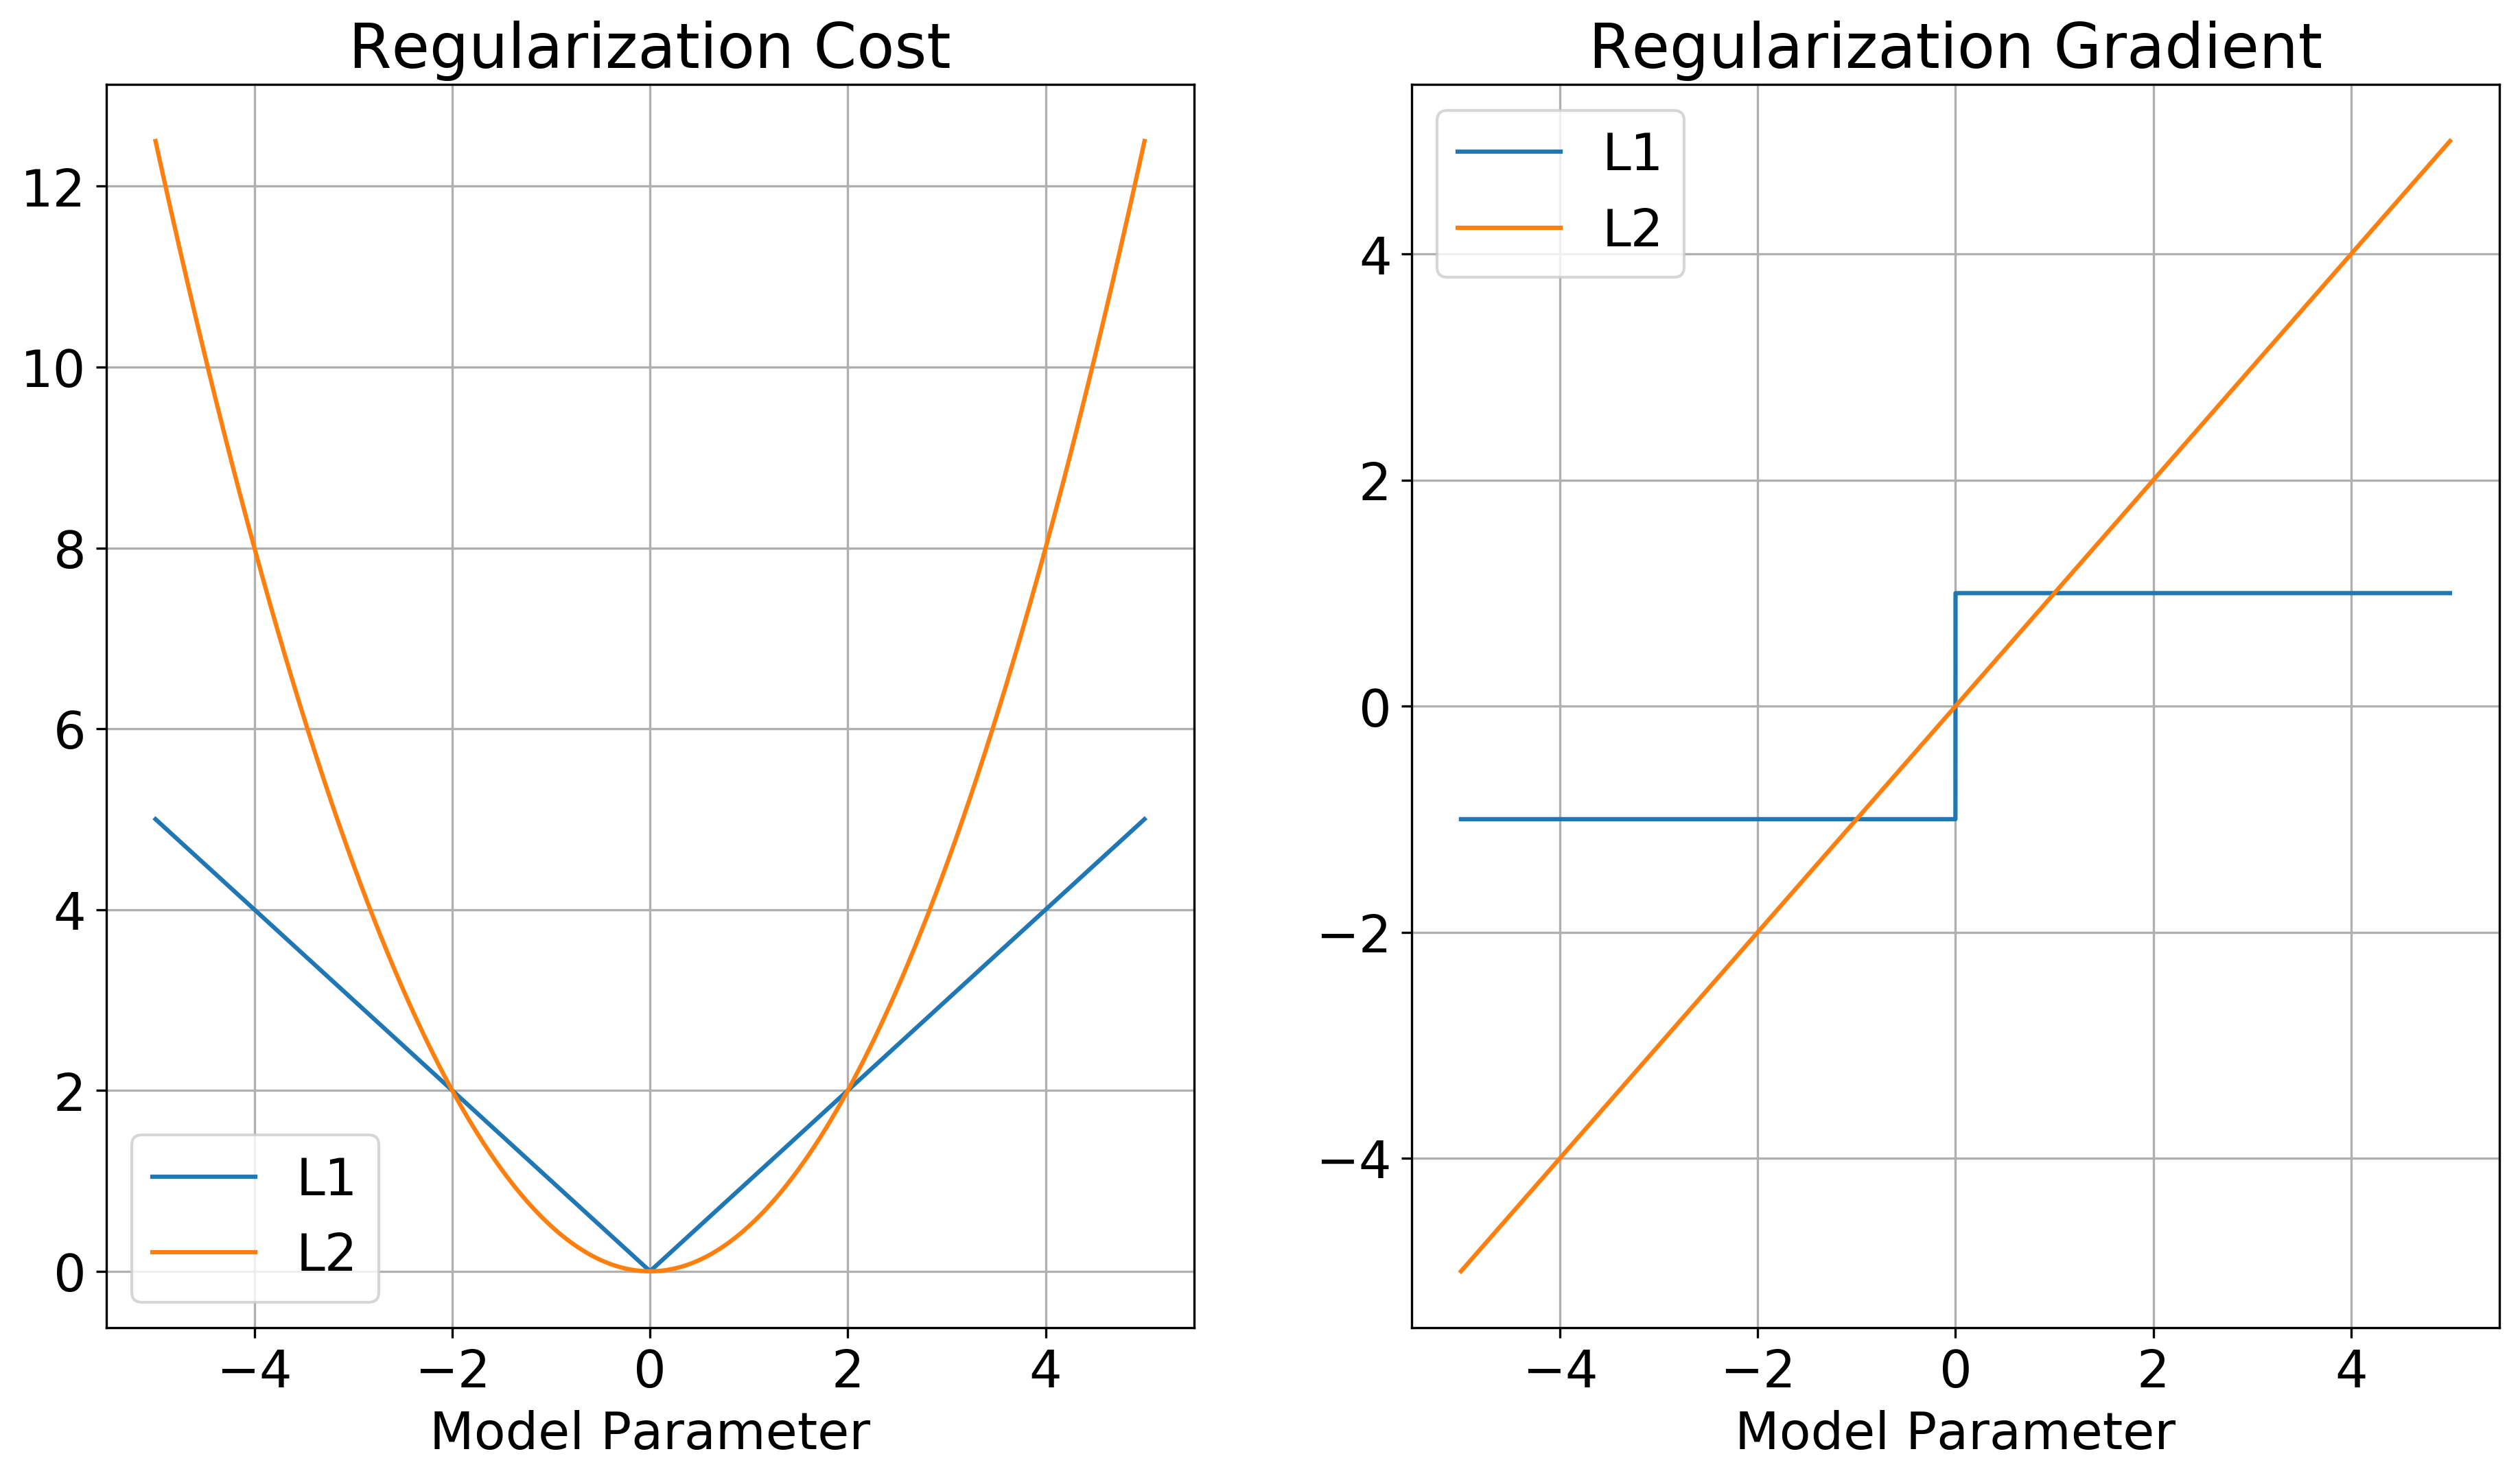

In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

theta = np.linspace(-5, 5, 10000)
l1 = np.abs(theta)
l2 = (theta ** 2) / 2

l1_gradient = np.empty(theta.shape)
l1_gradient[theta <= 0] = -1
l1_gradient[theta > 0] = 1

l2_gradient = theta

mpl.rcParams.update({'font.size': 18})
plt.figure(figsize=[15, 8], dpi=300)
plt.subplot(1, 2, 1)
plt.title('Regularization Cost')
sns.lineplot(theta, l1, label='L1')
sns.lineplot(theta, l2, label='L2')
plt.xlabel('Model Parameter')
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.subplot(1, 2, 2)
plt.title('Regularization Gradient')
sns.lineplot(theta, l1_gradient, label='L1')
sns.lineplot(theta, l2_gradient, label='L2')
plt.xlabel('Model Parameter')
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')

plt.show()

In [4]:
from tensorflow.keras import regularizers

# Docs: https://keras.io/regularizers/
regularizers.l1, regularizers.l2

(<function tensorflow.python.keras.regularizers.l1(l=0.01)>,
 <function tensorflow.python.keras.regularizers.l2(l=0.01)>)

# Dropout

At each iteration, we are going to disable randomly selected neurons, then do both forward and backward pass
with those neurons disabled. Numerically, we can sample a vector from Bernoulli distribution,
then multiply the neuron's activation matrix's with this vector column-wise (e.g. disabling the same neuron across all samples).

$$ p = \text{probability of keeping a node} $$
$$ \mathbf{d} = \text{vector of random variables ~ Bernoulli}(p)$$

Now we can zero-out randomly selected columns of the activation matrix:
$$ 
\tilde{\mathbf{a}}_{:, m}^{[1]} 
= \frac {\mathbf{a}_{:, m}^{[1]} * d_m} {p} 
$$

Why divide by $p$? To keep the mean across the features constant:

$$ 
\mathrm{E}[\tilde{\mathbf{a}}_{s, :}^{[1]}]
= \frac {\mathrm{E}[\mathbf{a}_{s, :}^{[1]}] * \mathrm{E}[\mathbf{d}]} {p} 
= \frac {\mathrm{E}[\mathbf{a}_{s, :}^{[1]}] * p}{p} 
= \mathrm{E}[\mathbf{a}_{s, :}^{[1]}]
$$

Why does this work as a regularization method? 
Intuitively, every node has to use information in all of its input nodes to minimize the impact of any particular input node being disabled. 
Numerically, this makes the L2-norm of the weights vector smaller.
Theoretically, it’s also similar to having an ensemble of neural networks, since each sampling of the dropout mask represents a different network.
Overall, the dropout introduces noise robustness to the model.

In [5]:
krom tensorflow.keras.layers import Dropout
?Dropout

Init signature: Dropout(rate, noise_shape=None, seed=None, **kwargs)
Docstring:     
Applies Dropout to the input.

Dropout consists in randomly setting
a fraction `rate` of input units to 0 at each update during training time,
which helps prevent overfitting.

Arguments:
    rate: float between 0 and 1. Fraction of the input units to drop.
    noise_shape: 1D integer tensor representing the shape of the
        binary dropout mask that will be multiplied with the input.
        For instance, if your inputs have shape
        `(batch_size, timesteps, features)` and
        you want the dropout mask to be the same for all timesteps,
        you can use `noise_shape=(batch_size, 1, features)`.
    seed: A Python integer to use as random seed.
File:           /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py
Type:           type
Subclasses:     SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, Dropout
